In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 43.2 MB/s eta 0:00:00


In [ ]:
!pip install pandas sentence-transformers faiss-cpu openpyxl tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, CrossEncoder, util
import faiss
import re

In [ ]:
EXCEL_PATH = '/content/drive/MyDrive/Extended AMUSED Dataset/Extended Amused dataset/Final dataset.xlsx'     # Your Excel file path
EVIDENCE_FOLDER = '/content/drive/MyDrive/Extended AMUSED Dataset/Extended Amused dataset/evidence'    # Folder with .txt evidence files
SHEET_NAME = 'Events'                  # Sheet to load
TOP_K = 10

In [ ]:
# 1. Load specific sheet from Excel
df = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME)
df = df.dropna(subset=['claim', 'claim-goldevidence'])  # Drop missing values

In [ ]:
# 2. Load all evidence files
evidence_texts = []
evidence_names = []

for fname in os.listdir(EVIDENCE_FOLDER):
    if fname.endswith(".txt"):
        with open(os.path.join(EVIDENCE_FOLDER, fname), 'r', encoding='utf-8') as f:
            text = f.read()
            evidence_texts.append(text.strip())
            evidence_names.append(fname.replace('.txt', ''))

In [ ]:
# 3. Preprocessing function
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

df['clean_claim'] = df['claim'].apply(preprocess)
evidence_texts = [preprocess(text) for text in evidence_texts]

In [ ]:
# 4. Load BGE model
print("🔄 Loading BGE model...")
bge_model = SentenceTransformer('BAAI/bge-base-en-v1.5')

🔄 Loading BGE model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# 5. Encode evidence texts
print("🔄 Encoding evidence documents...")
evidence_embeddings = bge_model.encode(evidence_texts, convert_to_numpy=True, show_progress_bar=True)


🔄 Encoding evidence documents...


Batches:   0%|          | 0/375 [00:00<?, ?it/s]

In [ ]:
# 6. Index with FAISS
embedding_dim = evidence_embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(embedding_dim)
faiss_index.add(np.array(evidence_embeddings))

In [ ]:
# 7. Retrieval + Reranking
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

results = []

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.66k [00:00<?, ?B/s]

In [ ]:
print("🚀 Processing claims...")
for idx, row in tqdm(df.iterrows(), total=len(df)):
    claim_id = row['claim-id']
    claim_text = row['clean_claim']
    gold_evidence = row['claim-goldevidence']

    # Encode the claim
    claim_embedding = bge_model.encode(claim_text, convert_to_numpy=True)

    # Retrieve top-k using FAISS
    D, I = faiss_index.search(np.array([claim_embedding]), TOP_K)
    retrieved_docs = [evidence_names[i] for i in I[0]]
    retrieved_texts = [evidence_texts[i] for i in I[0]]

    # Rerank using CrossEncoder
    rerank_inputs = [[claim_text, doc] for doc in retrieved_texts]
    rerank_scores = cross_encoder.predict(rerank_inputs)

    # Sort by score
    reranked = sorted(zip(retrieved_docs, rerank_scores), key=lambda x: x[1], reverse=True)
    reranked_names = [name for name, _ in reranked]

    # Compute MRR@10
    try:
        rank = reranked_names.index(gold_evidence) + 1
        reciprocal_rank = 1 / rank
    except ValueError:
        reciprocal_rank = 0.0

    # Save result
    results.append({
        'claim-id': claim_id,
        'claim': row['claim'],
        'gold-evidence': gold_evidence,
        'retrieved': reranked_names,
        'MRR@10': reciprocal_rank
    })

🚀 Processing claims...


100%|██████████| 188/188 [00:17<00:00, 10.90it/s]


In [ ]:
# 8. Results & Evaluation
results_df = pd.DataFrame(results)
mean_mrr = results_df['MRR@10'].mean()

print(f"\n✅ Mean Reciprocal Rank (MRR@10): {mean_mrr:.4f}")


✅ Mean Reciprocal Rank (MRR@10): 0.8996


In [ ]:
# Save to CSV
results_df.to_csv('retrieval_results.csv', index=False)
print("📁 Results saved to retrieval_results.csv")

📁 Results saved to retrieval_results.csv


The histogram presents the distribution of Mean Reciprocal Rank (MRR@10) scores across all evaluated claims. Each bar indicates the number of claims that achieved a particular range of MRR values within the retrieval system.

The MRR@10 metric ranges from 0.0 to 1.0, where:

A score of 1.0 means the gold evidence was ranked at the top (rank 1).

A score closer to 0.0 indicates the gold evidence was either ranked very low or not retrieved within the top 10 results.

This distribution provides insight into the effectiveness of the retrieval system. A right-skewed distribution (with more values closer to 1.0) suggests high retrieval performance, while a left-skewed or uniform distribution may indicate room for improvement in retrieving relevant evidence.

In this case, the histogram helps identify:

The proportion of claims where the retrieval system performed well (high MRR@10)

The number of failures or low-scoring instances

The overall variability in retrieval quality across the dataset



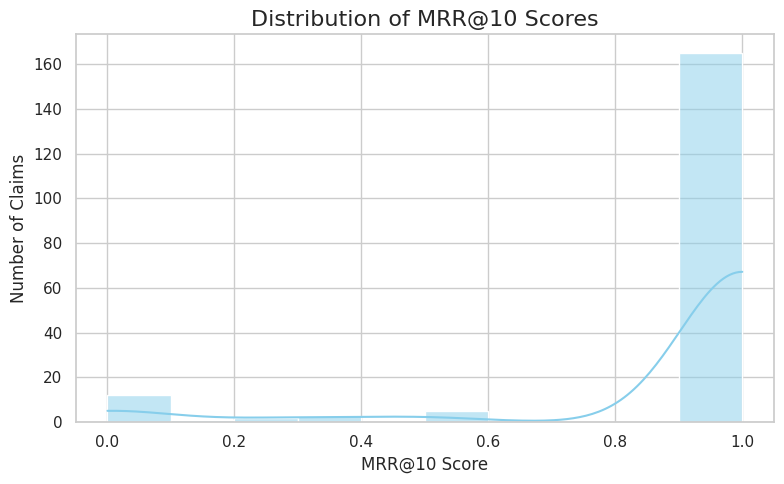

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set graph style
sns.set(style='whitegrid')

# 2. Histogram of MRR@10 Distribution(How many claims had low/high MRR@10 scores)
plt.figure(figsize=(8, 5))
sns.histplot(results_df['MRR@10'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of MRR@10 Scores', fontsize=16)
plt.xlabel('MRR@10 Score')
plt.ylabel('Number of Claims')
plt.tight_layout()
plt.savefig('mrr_distribution.png')
plt.show()


The line plot presents the Mean Reciprocal Rank at rank 10 (MRR@10) for each claim, sorted in descending order of performance. Each point on the curve represents a single claim's MRR score, with the x-axis indicating the rank position (not the claim ID) and the y-axis showing the corresponding MRR@10 value.

This visualization effectively highlights the overall retrieval quality across all claims:

A steep initial slope suggests that a significant number of claims achieved high MRR scores (i.e., their gold evidence appeared early in the ranked list).

The gradual decline that follows illustrates how the retrieval system's performance decreases across lower-ranked claims.

A flat tail near 0 indicates claims where the gold evidence was not found in the top-10 retrieved results, resulting in an MRR of 0.

This plot is especially useful for observing the consistency and robustness of the retrieval model across diverse inputs, helping to identify whether performance is concentrated among a few claims or distributed more evenly.


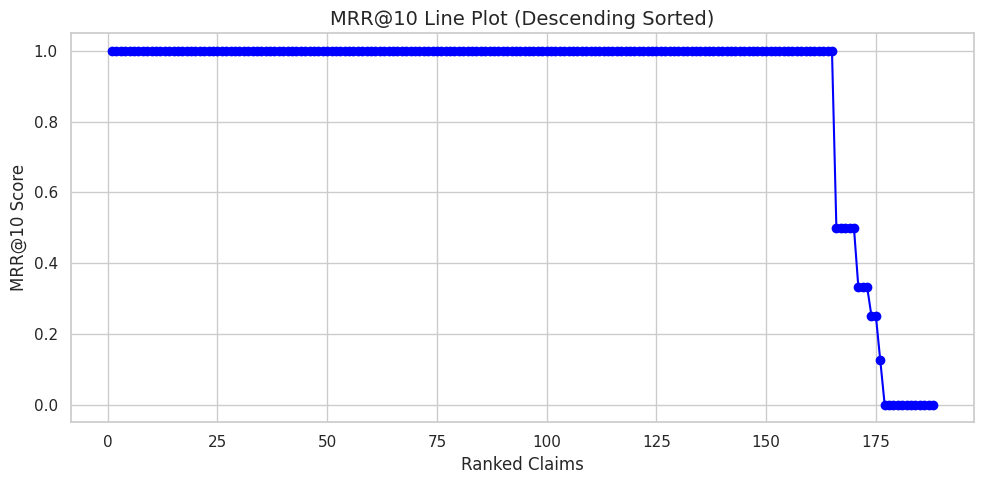

In [ ]:
plt.figure(figsize=(10, 5))
sorted_mrr = sorted(results_df['MRR@10'], reverse=True)
plt.plot(range(1, len(sorted_mrr)+1), sorted_mrr, marker='o', linestyle='-', color='blue')

plt.title('MRR@10 Line Plot (Descending Sorted)', fontsize=14)
plt.xlabel('Ranked Claims')
plt.ylabel('MRR@10 Score')
plt.grid(True)
plt.tight_layout()
plt.savefig('mrr_lineplot.png')
plt.show()
